In [11]:
import os
import re
import numpy as np
import sklearn.metrics

В предыдущей лабораторной был вопрос про то почему точность плохая

Моя "неверная" догадка была что дело в f-мере

`f1_score` из `sklearn` выдает на `np.zeros` точность $0$, а на `np.ones` точность $0.7$, если не передать `average`

In [12]:
def calcFScore(a, b):
    return sklearn.metrics.f1_score(a, b, average='micro')

In [13]:
def numsList(s):
    return np.array([int(i) for i in s.split()], dtype=np.longlong)

def thrower(s):
    raise Exception(s)

def loadFile(dir, file):
    with open(dir + file, "r") as f:
        cont = f.read()
    cont = cont.split('\n')
    cont = list(filter(lambda x: x.strip() != "", cont))
    assert len(cont) == 2
    return \
        ( 0 if "spmsg" in file else 1 if "legit" in file else thrower("Wrong " + file)
        , numsList(cont[0][9:]) + 1
        , numsList(cont[1]) + 1
        )
        

folds = []
for i in range(1, 11):
    dir = './messages/part' + str(i) + '/'
    folds.append([])
    for file in os.listdir(dir):
        folds[-1].append(loadFile(dir, file))

In [14]:
print(folds[0][:3])

[(0, array([14487], dtype=int64), array([14487,    81,   197,    65,  1897,  8963, 14329,  2131, 16503,
        9212,    85,   197,  4340,   181, 16927, 18248, 18958, 14404,
        4054, 23477,  2131, 16503,   753, 23267, 17349,  8858,  1992,
       16503, 16927,    85,  1813, 17346, 21367, 15821, 18999,    85,
          85,    85,   766,  4785,    85,  1813, 15692,    81, 18949,
         197,  1592, 16086, 14339, 19055, 10249,    85,   119,    71],
      dtype=int64)), (0, array([12092, 16399, 21904,  1409,    63,  2548, 10547,  3296,  2411],
      dtype=int64), array([   87,    87,    87, ..., 11677, 13521,    85], dtype=int64)), (0, array([2057,  119, 4054,   48], dtype=int64), array([19072,    81,  2177, 13473,  9670,   181, 22482,  6309,    62,
        4054,  5160,  2131, 16503, 11318, 23227, 23423, 18248,  1836,
       16503,  5332,    85,  8963, 13887, 16503, 16862,  2131, 14329,
         131,  4054,  5160,    85,  1969,  8240,    85, 17346, 14329,
       21991, 17346, 16251,  

In [15]:
minWord = 10**18
maxWord = -10**18
allWords = set()
justWords = 0
for f in folds:
    for n in f:
        justWords += len(n[1])
        justWords += len(n[2])
        minWord = n[2].min(initial=n[1].min(initial=minWord))
        maxWord = n[2].max(initial=n[1].max(initial=maxWord))
        allWords.update(n[1])
        allWords.update(n[2])
print('any\t', justWords)
print('diff\t', len(allWords))
print('ratio\t', len(allWords)/justWords)
print('min\t', minWord)
print('max\t', maxWord)
assert minWord > 0
assert maxWord < 2**16
maxWordRounded = maxWord - 1
maxWordRounded |= maxWordRounded >> 1
maxWordRounded |= maxWordRounded >> 2
maxWordRounded |= maxWordRounded >> 4
maxWordRounded |= maxWordRounded >> 8
maxWordRounded |= maxWordRounded >> 16
maxWordRounded += 1
print('rnded', maxWordRounded)

any	 846167
diff	 24728
ratio	 0.02922354570669856
min	 1
max	 24748
rnded 32768


In [16]:
def calcAnagramms(s, n):
    mul = 1
    prev = s
    res = [s]
    for i in range(1, n):
        mul *= maxWordRounded
        prev = prev + np.roll(s, i) * mul
        res.append(prev)
    return np.concatenate(res)

In [17]:
class Estim:
    def __init__(self, ngrams):
        self.ngrams = ngrams
    def predict(self, xs, lmb=1):
        return np.fromiter(map(lambda x: self.predict1(x, lmb), xs), int)

In [18]:
def EstimPrepMsg(self, s, msg):
    for i in range(2):
        s.update(calcAnagramms(msg[i], self.ngrams))
    return s
Estim.prepMsg = EstimPrepMsg

In [21]:
def EstimTrain(self, folds, display=False):
    self.folds = folds
    foldWords = []
    allFeatures = set()
    for f in folds:
        cur = set()
        for n in f:
            self.prepMsg(cur, n[1:])
        allFeatures.update(cur)
        foldWords.append((n[0], np.fromiter(cur, np.longlong)))
    self.allFeatures = np.fromiter(allFeatures, np.longlong)
    self.foldWords = foldWords
    if display:
        print('n\t', self.ngrams)
        print('in 1\t', foldWords[0][1].shape[0])
        print('all\t', len(allFeatures))
    countSpam = 0
    countLegi = 0
    probabSpam = {}
    probabLegi = {}
    for i in self.allFeatures:
        probabSpam[i] = 0
        probabLegi[i] = 0
    for f in self.folds:
        for n in f:
            if n[0] == 0:
                countSpam += 1
            elif n[0] == 1:
                countLegi += 1
            else:
                raise Exception(n[0])
    for f in self.folds:
        for n in f:
            cr = probabSpam if n[0] == 0 else probabLegi if n[0] == 1 else thrower(str(n[0]))
            for e in n[1]:
                cr[e] += 1
    self.probabSpamPre = probabSpam
    self.probabLegiPre = probabLegi
    self.countSpam = countSpam
    self.countLegi = countLegi

def EstimCalcProbab(self, alpha):
    # Q = 2
    Q = len(self.allFeatures)
    countSpam = self.countSpam
    countLegi = self.countLegi
    self.probabSpam = {k: (v + alpha) / (countSpam + alpha * Q) for k, v in self.probabSpamPre.items()}
    self.probabLegi = {k: (v + alpha) / (countLegi + alpha * Q) for k, v in self.probabLegiPre.items()}
    allAbsentMult = 1
    probabSpam = self.probabSpam
    probabLegi = self.probabLegi
    for word in self.allFeatures:
        sp = probabSpam[word]
        le = probabLegi[word]
        if sp == 1 or le == 1:
            continue
        allAbsentMult *= (1 - sp) / (1 - le)
    self.allAbsentMult = allAbsentMult
Estim.calcProbab = EstimCalcProbab
Estim.train = EstimTrain

In [22]:
e = Estim(3)
e.train(folds, display=True)
e.calcProbab(0)

n	 3
in 1	 117211
all	 551293


In [23]:
def EstimPredict1V(self, msg, lmb):
    msg = self.prepMsg(set(), msg)
    res = lmb * self.countSpam / self.countLegi * self.allAbsentMult # isSpam / isLegit = p(spam)/p(legit)
    for k in msg:
        sp = self.probabSpam.get(k, 0)
        le = self.probabLegi.get(k, 0)
        if sp == 0 or le == 0 or sp == 1 or le == 1:
            continue
        res *= (1 - le) / (1 - sp) * sp / le
    return res
def EstimPredict1(self, msg, lmb):
    return 0 if EstimPredict1V(self, msg, lmb) > 1 else 1
Estim.predict1 = EstimPredict1

In [24]:
tryN = [1, 2, 3]
tryAlpha = [0, 0.1, 100, 1, 10, 0.001, 0.0001, 10**6]
lele = len(folds)
# lele = 2

In [25]:
qresults = []
def proc(train, testX, testY):
    results = {}
    for ngram in tryN:
        print('\tn =', ngram)
        est = Estim(ngram)
        est.train(train)
        print('\t\ta', end='')
        for alpha in tryAlpha:
            print('\t' + str(alpha), end='')
            est.calcProbab(alpha)
            predY = est.predict(testX)
            score = calcFScore(testY, predY)
            results[(ngram, alpha)] = score
        print()
    # qresults.put(results)
    qresults.append(results)

In [26]:
%%time
def setOrAdd(d, dflt, k, v):
    d[k] = d.get(k, 0) + v / dflt

avg = 0

for n in range(lele):
    print('fold ', n)
    train = folds[:n] + folds[n+1:]
    test = folds[n]
    testY = np.fromiter(map(lambda x: x[0], test), dtype=int)
    testX = [x[1:] for x in test]
    proc(train, testX, testY)

fold  0
	n = 1
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n = 2
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n = 3
		a	0	0.1	100	1	10	0.001	0.0001	1000000
fold  1
	n = 1
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n = 2
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n = 3
		a	0	0.1	100	1	10	0.001	0.0001	1000000
fold  2
	n = 1
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n = 2
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n = 3
		a	0	0.1	100	1	10	0.001	0.0001	1000000
fold  3
	n = 1
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n = 2
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n = 3
		a	0	0.1	100	1	10	0.001	0.0001	1000000
fold  4
	n = 1
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n = 2
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n = 3
		a	0	0.1	100	1	10	0.001	0.0001	1000000
fold  5
	n = 1
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n = 2
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n = 3
		a	0	0.1	100	1	10	0.001	0.0001	1000000
fold  6
	n = 1
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n = 2
		a	0	0.1	100	1	10	0.001	0.0001	1000000
	n =

In [27]:
# print(qresults)
results = {}
for qr in qresults:
    for ngram in tryN:
        for alpha in tryAlpha:
            results[ngram, alpha] = results.get((ngram, alpha), 0) + qr[ngram, alpha] / lele
print(results)

{(1, 0): 0.4990825688073394, (1, 0.1): 0.6779816513761469, (1, 100): 0.8908256880733945, (1, 1): 0.708256880733945, (1, 10): 0.7999999999999999, (1, 0.001): 0.6458715596330274, (1, 0.0001): 0.6568807339449542, (1, 1000000): 0.5596330275229356, (2, 0): 0.4990825688073394, (2, 0.1): 0.691743119266055, (2, 100): 0.8908256880733945, (2, 1): 0.7128440366972478, (2, 10): 0.8009174311926605, (2, 0.001): 0.5779816513761469, (2, 0.0001): 0.5752293577981651, (2, 1000000): 0.5596330275229356, (3, 0): 0.4990825688073394, (3, 0.1): 0.698165137614679, (3, 100): 0.8908256880733945, (3, 1): 0.7146788990825689, (3, 10): 0.8009174311926605, (3, 0.001): 0.5853211009174311, (3, 0.0001): 0.5348623853211009, (3, 1000000): 0.5596330275229356}


In [28]:
bestModel = sorted(results.items(), key=lambda x: x[1])[-1]
print(bestModel)
bestModel = bestModel[0]

((3, 100), 0.8908256880733945)


In [29]:
%%time
train = folds[1:]
test = folds[0]
testY = np.fromiter(map(lambda x: x[0], test), dtype=int)
testX = [x[1:] for x in test]
est = Estim(bestModel[0])
est.train(train)
est.calcProbab(bestModel[1])

Wall time: 1.65 s


In [39]:
%%time
nbad = []
xs = []
accur = []
tpr = []
fpr = []
for i in \
        [0] \
        + list(map(np.exp, range(-6, 5))) \
        + list(map(lambda x: 1 - 10**-x, range(1, 4))) \
        + list(map(lambda x: 1 + 10**-x, range(1, 4))) \
        + list(np.arange(0, 1, 0.03)):
    # print(i)
    xs.append(i)
    predY = est.predict(testX, i)
    tp = np.sum((predY == 1) & (testY == 1))
    tn = np.sum((predY == 0) & (testY == 0))
    fp = np.sum((predY == 1) & (testY == 0))
    fn = np.sum((predY == 0) & (testY == 1))
    nbad.append(fn)
    tpr.append(tp / (tp + fn))
    fpr.append(fp / (fp + tn))
    accur.append(calcFScore(testY, predY))

print(np.max(accur))

0.9174311926605505
Wall time: 12 s


In [31]:
aaaa = list(zip(xs, nbad, accur))
print(aaaa)

[(0, 0, 0.5596330275229358), (0.0024787521766663585, 0, 0.5596330275229358), (0.006737946999085467, 0, 0.5596330275229358), (0.01831563888873418, 0, 0.5688073394495413), (0.049787068367863944, 0, 0.6513761467889908), (0.1353352832366127, 1, 0.743119266055046), (0.36787944117144233, 3, 0.8623853211009176), (1.0, 7, 0.9174311926605505), (2.718281828459045, 17, 0.8440366972477065), (7.38905609893065, 27, 0.7522935779816514), (20.085536923187668, 41, 0.6238532110091743), (54.598150033144236, 51, 0.5321100917431193), (0.9, 7, 0.9174311926605505), (0.99, 7, 0.9174311926605505), (0.999, 7, 0.9174311926605505), (1.1, 9, 0.8990825688073395), (1.01, 7, 0.9174311926605505), (1.001, 7, 0.9174311926605505), (0.0, 0, 0.5596330275229358), (0.03, 0, 0.6055045871559633), (0.06, 0, 0.6513761467889908), (0.09, 0, 0.6972477064220184), (0.12, 1, 0.7064220183486238), (0.15, 1, 0.7614678899082569), (0.18, 1, 0.7889908256880734), (0.21, 1, 0.81651376146789), (0.24, 2, 0.8440366972477065), (0.27, 2, 0.86238532

In [38]:
aaaaSorted = sorted(aaaa, key=lambda x: x[0])
xs, nbad, accur = list(zip(*aaaaSorted))

In [33]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

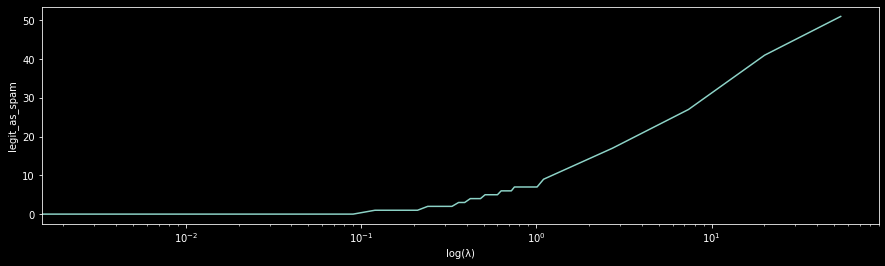

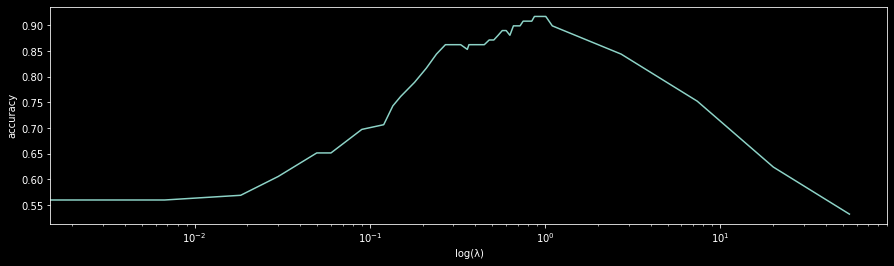

In [34]:
plt.figure(figsize=(15,4))
plt.plot(xs, nbad)
plt.xscale('log')
plt.xlabel('log(λ)')
plt.ylabel('legit_as_spam')
plt.show();
plt.figure(figsize=(15,4))
plt.plot(xs, accur)
plt.xscale('log')
plt.xlabel('log(λ)')
plt.ylabel('accuracy')
plt.show();

In [35]:
# as lambda, bad, accur
for a in aaaaSorted[:10]:
    print(a)

(0, 0, 0.5596330275229358)
(0.0, 0, 0.5596330275229358)
(0.0024787521766663585, 0, 0.5596330275229358)
(0.006737946999085467, 0, 0.5596330275229358)
(0.01831563888873418, 0, 0.5688073394495413)
(0.03, 0, 0.6055045871559633)
(0.049787068367863944, 0, 0.6513761467889908)
(0.06, 0, 0.6513761467889908)
(0.09, 0, 0.6972477064220184)
(0.12, 1, 0.7064220183486238)


^ видно, что при переходах около 0.11-0.13 появляется 1 не спам распознанный как спам
# ROC

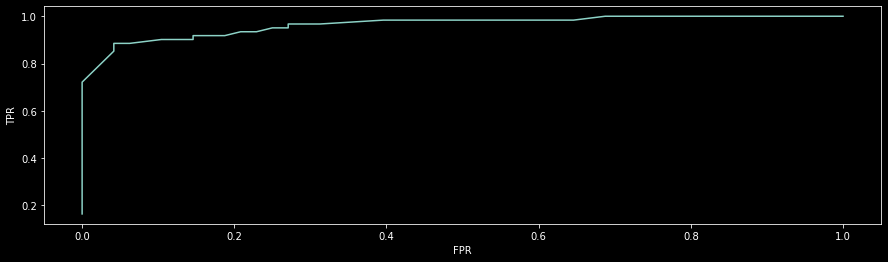

In [36]:
plt.figure(figsize=(15,4))
plt.xlabel('FPR')
plt.ylabel('TPR')
fpr, tpr = zip(*sorted(zip(fpr, tpr)))
plt.plot(fpr, tpr)
plt.show();